In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
from libs.common import *

c:\Users\Admin\Data\ads_fraud_detection
c:/Users/Admin/Data/ads_fraud_detection


In [2]:
save_dir=f"{exps_dir}/exp1/exp_gan"
if os.path.exists(save_dir) == False:
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [3]:
feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
feature_selection = {key: value for key, value in feature_selection.item().items()}
feature_selection

{'LR': ['day_incident_date',
  'day_policy_bind_date',
  'incident_severity',
  'injury_claim',
  'month_policy_bind_date',
  'policy_annual_premium',
  'property_claim',
  'total_claim_amount',
  'vehicle_claim',
  'year_policy_bind_date'],
 'LDA': ['day_incident_date',
  'incident_severity',
  'injury_claim',
  'insured_sex',
  'month_policy_bind_date',
  'policy_annual_premium',
  'property_claim',
  'total_claim_amount',
  'vehicle_claim',
  'year_policy_bind_date'],
 'DTC': ['day_incident_date',
  'incident_severity',
  'incident_state',
  'injury_claim',
  'insured_hobbies',
  'insured_occupation',
  'month_policy_bind_date',
  'policy_annual_premium',
  'policy_state',
  'year_policy_bind_date'],
 'RD': ['day_incident_date',
  'incident_severity',
  'incident_state',
  'injury_claim',
  'insured_hobbies',
  'policy_annual_premium',
  'policy_state',
  'property_claim',
  'total_claim_amount',
  'year_policy_bind_date'],
 'LGBM': ['day_incident_date',
  'day_policy_bind_date',
  

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [4]:
xgb_model=joblib.load(f'{save_dir}/xgb_model.joblib')
rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
lgbm_model=joblib.load(f'{save_dir}/lgbm_model.joblib')

In [5]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.9980430528375733, 1: 1.0019646365422397}

In [6]:
category_columns=dict(np.load(f'{exps_dir}/exp1/columns_dtype.npz',allow_pickle=True))['category_columns']
for column in category_columns:
    if column=="fraud_reported":
        continue
    label_encoder = LabelEncoder()
    x_test[column] = label_encoder.fit_transform(x_test[column])
y_train[column] = label_encoder.fit_transform(y_train[column])
y_test[column] = label_encoder.fit_transform(y_test[column])


In [7]:
x_train

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,day_policy_bind_date,month_policy_bind_date,year_policy_bind_date,day_incident_date,month_incident_date,year_incident_date
0,0,2,11,1,2,-0.135115,0,1,6,2,9,1,-0.940368,0.809323,3,0,3,3,27,52,1,0,1,2,1,2,-1.676803,-1.182425,-1.288254,-1.729038,11,19,2,-1.423969,-0.446155,0.986569,-1.174354,0.998447,0
1,1,1,12,0,1,0.495180,0,0,2,10,3,2,0.655758,0.809323,2,1,1,1,52,19,2,0,1,2,1,1,0.337853,-0.064942,-0.211904,0.310913,13,28,1,-0.862658,1.249789,-1.531699,1.432852,0.998447,0
2,1,2,12,2,0,0.341022,0,1,4,8,18,5,-0.940368,0.809323,2,1,0,1,49,106,0,0,1,1,1,1,0.774402,0.034155,-0.116454,0.822176,4,30,0,-0.413609,-1.576785,-1.657613,0.979425,-0.908699,0
3,1,0,11,2,0,0.005199,0,1,2,11,0,3,-0.940368,-0.503457,2,1,2,2,26,126,0,0,1,2,0,2,0.775198,1.195916,1.002544,0.260909,5,16,1,-0.189085,0.684474,-1.783526,-0.947640,-0.908699,0
4,0,2,36,0,2,-0.009186,5,0,3,4,16,5,-0.940368,-0.947582,0,2,0,1,49,52,0,1,2,1,0,1,0.237479,1.136879,-0.268768,-0.094220,5,14,2,1.831635,-0.163498,0.860655,0.185927,0.998447,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,0,2,12,1,0,0.623489,3,0,5,12,8,0,0.598539,0.809323,2,3,2,3,49,147,0,0,2,2,3,1,1.717204,2.102553,1.875808,1.028824,0,31,2,-1.199445,-1.859442,0.608828,0.525998,-0.908699,0
1016,1,2,12,2,0,-1.738381,5,1,2,6,15,4,0.670816,0.809323,2,3,2,3,52,105,1,0,1,0,2,2,1.195815,1.600740,-0.045374,0.965044,11,21,2,0.035440,0.967132,-0.020739,-0.720927,-0.908699,0
1017,1,0,4,2,0,1.655908,0,1,2,2,16,2,-0.940368,0.809323,0,3,0,0,8,36,0,2,1,2,1,2,-0.262800,-0.386482,1.519598,-1.525451,9,29,2,0.484489,1.249789,-0.020739,1.432852,0.998447,0
1018,1,0,11,2,2,1.255443,0,1,5,11,8,2,0.198001,0.809323,2,1,1,1,43,52,1,0,1,0,3,0,0.650925,0.871213,0.689793,0.258868,5,14,1,1.494849,-1.294127,-1.783526,0.866068,-0.908699,0


In [8]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse=False)

    labels_reshaped = labels.reshape(-1, 1)

    encoder.fit(labels_reshaped)

    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(330, 2) (1020, 2)


In [9]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(330, 2)


In [10]:
x_test.shape

(330, 39)

In [11]:
x_train.shape

(1020, 39)

In [12]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    y_pred = K.round(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())
    macro_f1_score = K.mean(f1_scores)

    return macro_f1_score

In [13]:
print(x_train.shape[1])

39


#### * Xây dựng model:

In [14]:

early_stopping = EarlyStopping(monitor='f1_score',
                                mode='max',
    min_delta=0.00005,
    patience=100,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='f1_score',
    mode='max',
    factor=0.5,
    patience=10,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Đường dẫn để lưu model
    monitor='f1_score',  # Theo dõi val_loss
    mode='max',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1  # Hiển thị thông báo khi lưu model
)



#### * Xây dựng Stacked_model:

In [15]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import tensorflow as tf
from tabnet_keras import TabNetClassifier

class TabNetWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def fit(self, X, y):
        self.model = TabNetClassifier(n_classes = 1, out_activation = 'sigmoid',**self.kwargs)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy',f1_score])

        self.model.fit(X, y, epochs=10, batch_size=64, class_weight={0:0.6,1:0.4})
        return self

    def predict(self, X):
        proba = self.model.predict(X)
        return (proba > 0.5).astype(int)

    def predict_proba(self, X):
        return self.model.predict(X)

    def summary(self):
        return self.model.summary()

In [16]:
tabnet_params = {
    "decision_dim": 16,
    "attention_dim": 16,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3,
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}
tabnet = TabNetWrapper(**tabnet_params)


In [17]:
from sklearn.ensemble import StackingClassifier

# def create_keras_model():
#     # Thêm các lớp khác vào đây
#     best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score])
#     best_model.load_weights('weights.h5')
#     return best_model

# tabnet = KerasClassifier(build_fn=create_keras_model, epochs=10)

# rf_model=RandomForestClassifier(n_estimators=100, random_state=seed)
# bg_model=GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=seed)
# svm_model=SVC(kernel='rbf',probability=True, gamma='scale' , random_state=seed)

# # Huấn luyện các mô hình cơ sở
# rf_model.fit(x_train, y_train)
# bg_model.fit(x_train, y_train)
# svm_model.fit(x_train, y_train)


# Dự đoán đầu ra của các mô hình cơ sở
rf_pred = rf_model.predict_proba(x_test[feature_selection['RD']])
svm_pred = lgbm_model.predict_proba(x_test[feature_selection['LGBM']])
bg_pred = xgb_model.predict_proba(x_test[feature_selection['XGB']])



# keras_pred = tabnet.predict(x_test)
stacked_input = np.column_stack((rf_pred,svm_pred,bg_pred))


#history=model.fit(x=x_train,y=y_train,
          #validation_data=(x_test,y_test),class_weight=class_weights_dict ,
          #batch_size=64,epochs=120, callbacks=[confusion_matrix_callback])

# tabnet = KerasClassifier(build_fn=model_output, tabnet_params=tabnet_params,batch_size=64,epochs=10000,callbacks=[early_stopping,lr_scheduler])

# Clone lại để tránh thay đổi trực tiếp vào mô hình gốc
# tabnet = clone(tabnet)
# Xây dựng mô hình stacking
stacked_model = StackingClassifier(
    estimators=[('rf',rf_model), ('lgbm',lgbm_model),('xgb',xgb_model)],
    final_estimator=tabnet
)
print(stacked_input.shape)
print(y_test.shape)
# Tiếp tục với việc huấn luyện và đánh giá mô hình stacking
stacked_model.fit(stacked_input, y_test)
stacked_pred = stacked_model.predict(stacked_input)
# stacked_pred

(330, 6)
(330, 1)
[LightGBM] [Info] Number of positive: 88, number of negative: 242
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 330, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266667 -> initscore=-1.011601
[LightGBM] [Info] Start training from score -1.011601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [18]:
# rf_pred = rf_model.predict_proba(x_test[feature_selection['RD']])
# svm_pred = lgbm_model.predict_proba(x_test[feature_selection['LGBM']])
# bg_pred = xgb_model.predict_proba(x_test[feature_selection['XGB']])
# stacked_input = np.column_stack((rf_pred,svm_pred,bg_pred))
stacked_pred = stacked_model.predict(stacked_input)


11/11 [==============================] - 0s 1ms/step


In [19]:
stacked_pred

array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,

In [20]:
# stacked_model.fit(stacked_input, y_test)
# Dự đoán và đánh giá mô hình stacked
# stacked_pred = stacked_model.predict(stacked_input)
stacked_pred_labels = (stacked_pred > 0.5).astype(int)
accuracy_stacked = accuracy_score(y_test, stacked_pred_labels)
print(f'Accuracy of Stacked Model: {accuracy_stacked}')

Accuracy of Stacked Model: 0.03333333333333333


#### * Kết quả đánh giá mô hình:

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




accuracy = accuracy_score(y_test, stacked_pred_labels)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, stacked_pred_labels,labels=[1,0]))

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.03333333333333333
Classification Report:
              precision    recall  f1-score   support

           1       0.02      0.05      0.02        88
           0       0.08      0.03      0.04       242

    accuracy                           0.03       330
   macro avg       0.05      0.04      0.03       330
weighted avg       0.06      0.03      0.04       330



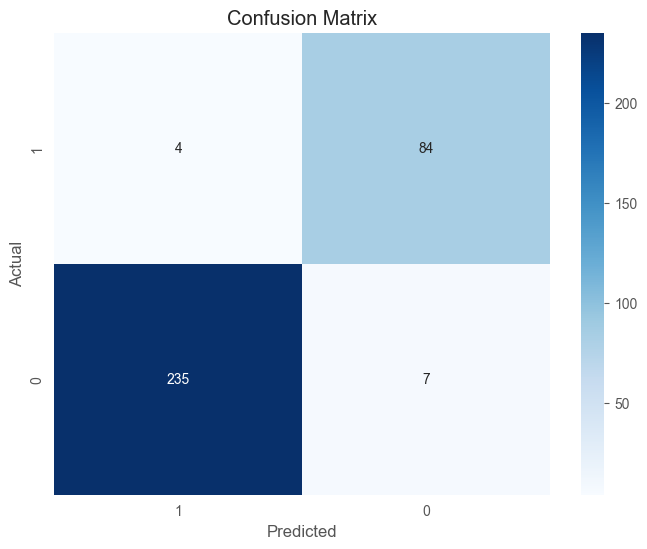

In [22]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, stacked_pred_labels,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

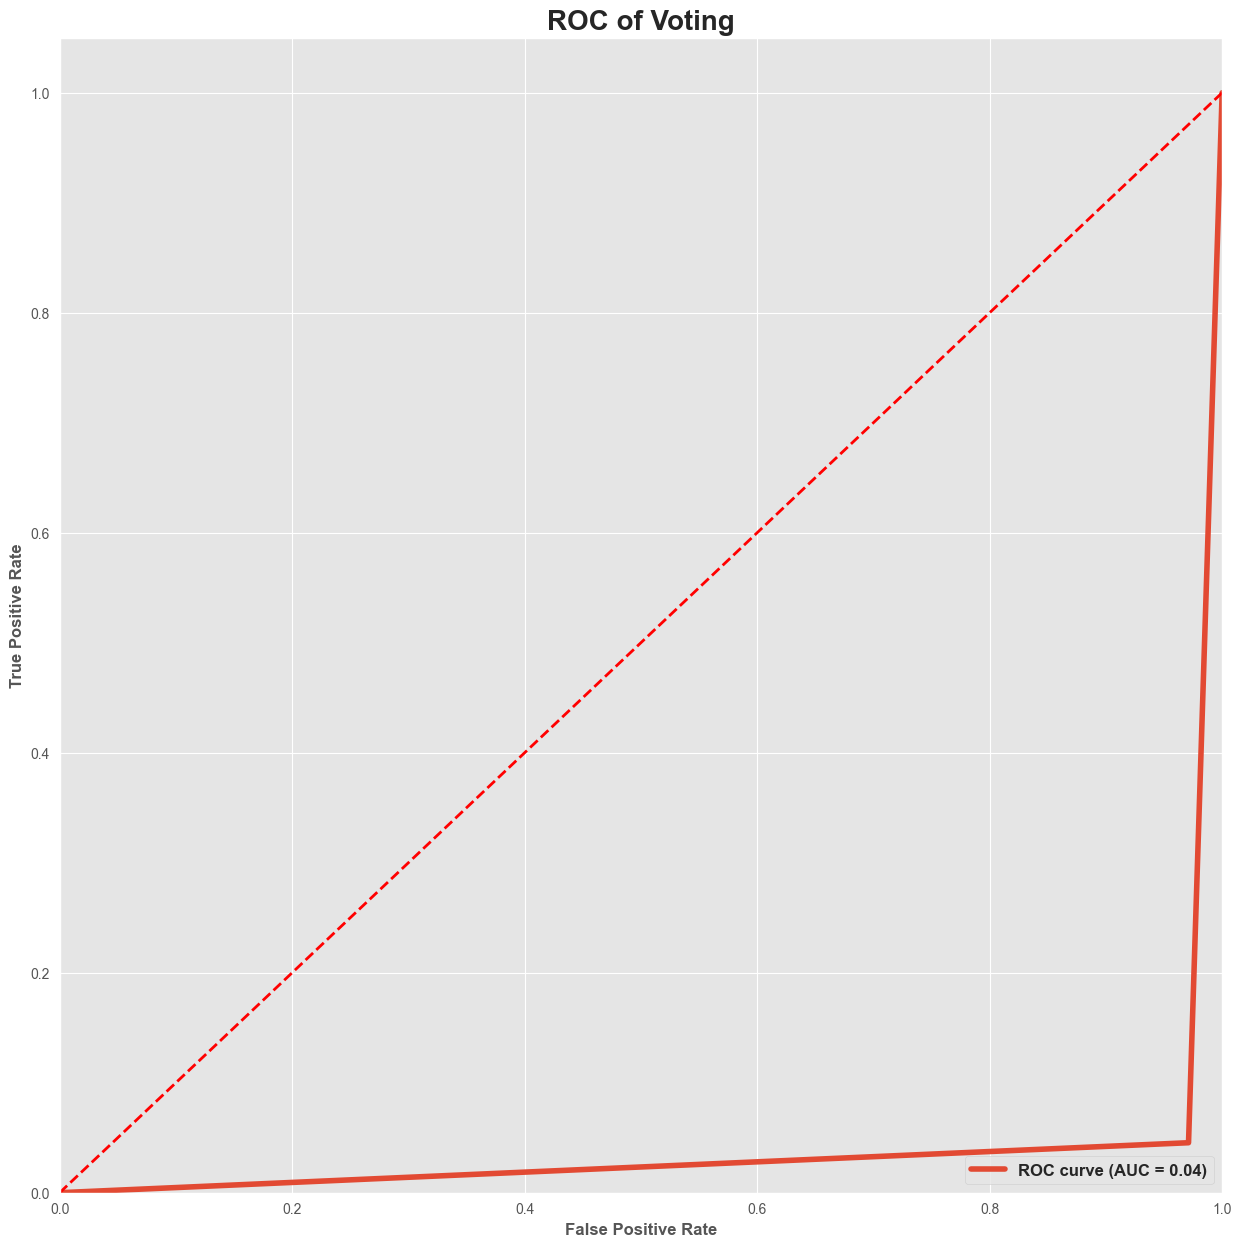

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, stacked_pred)

roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})
plt.show()